In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# 모델 레이어 구성
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [48]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

numpy.ndarray

In [9]:
# 모델 설정
model.compile(
    optimizer = keras.optimizers.RMSprop(),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [keras.metrics.SparseCategoricalAccuracy()],
)

In [10]:
# fitting
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    validation_data = (x_val, y_val)
)

Epoch 1/2
782/782 [==============================] - 2s 1ms/step - loss: 0.3322 - sparse_categorical_accuracy: 0.9060 - val_loss: 0.2208 - val_sparse_categorical_accuracy: 0.9357
Epoch 2/2
782/782 [==============================] - 1s 1ms/step - loss: 0.1575 - sparse_categorical_accuracy: 0.9527 - val_loss: 0.1403 - val_sparse_categorical_accuracy: 0.9583


In [11]:
history.history

{'loss': [0.3321518898010254, 0.15748603641986847],
 'sparse_categorical_accuracy': [0.9060199856758118, 0.9526799917221069],
 'val_loss': [0.2208210974931717, 0.14029808342456818],
 'val_sparse_categorical_accuracy': [0.935699999332428, 0.958299994468689]}

In [12]:
# evaluate()를 통해 테스트 데이터에 대한 모델을 평가. 
results = model.evaluate(x_test, y_test, batch_size=128)
print(f"test loss, test acc: {results}")

# 예측하기
predictions = model.predict(x_test[:3])
print(f"predictions shape : {predictions.shape}")

79/79 [==============================] - 0s 1ms/step - loss: 0.1402 - sparse_categorical_accuracy: 0.9582
test loss, test acc: [0.14016923308372498, 0.9581999778747559]
predictions shape : (3, 10)


In [13]:
# compile 메서드 상세
# metrics은 모니터링 용
model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate=1e-3),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [17]:
# 재사용을 위해 모델 정의와 컴파일 단계를 함수에 넣음

def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predcitions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model

In [18]:
def custom_mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true - y_pred))

model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=custom_mean_squared_error)

y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

782/782 [==============================] - 1s 936us/step - loss: 0.0157


In [22]:
class CustomMSE(keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="custom_mse"):
        super(CustomMSE, self).__init__(name=name)
        self.regularization_factor = regularization_factor
    
    def call(self, y_true, y_pred):
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        return mse + reg * self.regularization_factor

    
model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=CustomMSE())

y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

[5. 0. 4. ... 8. 4. 8.]
782/782 [==============================] - 1s 919us/step - loss: 0.0384


In [30]:
# custom metrics
# true : 정답 
# positive 맞다고 예측하는 것

class CategoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))
    
    def result(self):
        return self.true_positives
    
    # 각 epoch 시작 지점에서 metric의 상태를 초기화 시킴. 
    def reset_states(self):
        self.true_positives.assign(0.0)


model = get_uncompiled_model()
model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate=1e-3),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [CategoricalTruePositives()],
)
model.fit(x_train, y_train, batch_size=64, epochs=3)

Epoch 1/3
782/782 [==============================] - 1s 953us/step - loss: 0.3454 - categorical_true_positives: 45067.0000
Epoch 2/3
782/782 [==============================] - 1s 1ms/step - loss: 0.1598 - categorical_true_positives: 47621.0000
Epoch 3/3
782/782 [==============================] - 1s 945us/step - loss: 0.1164 - categorical_true_positives: 48220.0000


In [36]:
# 표준 서명에 맞지 않는 손실 및 메트릭 처리.

class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs

inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

x = ActivityRegularizationLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate=1e-3),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
)

model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 1s 931us/step - loss: 2.4611


In [43]:
# add_metric()

class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        self.add_metric(
            keras.backend.std(inputs), name="std_of_activation", aggregation="mean"
        )
        return inputs


inputs = keras.Input(shape=(784, ), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

x = MetricLoggingLayer()(x)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate=1e-3),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 1s 996us/step - loss: 0.3392 - std_of_activation: 1.0068


In [45]:
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x2 = layers.Dense(64, activation="relu", name="dense_2")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

model.add_loss(tf.reduce_sum(x1) * 0.1)

model.add_metric(keras.backend.std(x1), name="std_of_activation", aggregation="mean")

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 1s 1ms/step - loss: 2.5270 - std_of_activation: 0.0021


In [46]:
class LogisticEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super(LogisticEndpoint, self).__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.accuracy_fn = keras.metrics.BinaryAccuracy()
    
    def call(self, targets, logits, sample_weights=None):
        loss = self.loss_fn(targets, logits, sample_weights)
        self.add_loss(loss)
        
        acc = self.accuracy_fn(targets, logits, sample_weights)
        self.add_metric(acc, name="accuracy")
        
        return tf.nn.softmax(logits)

In [47]:
import numpy as np

inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs)
predictions = LogisticEndpoint(name="predictions")(logits, targets)

model = keras.Model(inputs=[inputs, targets], outputs=predictions)
model.compile(optimizer="adam")

data = {
    "inputs" : np.random.random((3, 3)),
    "targets" : np.random.random((3, 10)),
}

model.fit(data)

1/1 [==============================] - 0s 290ms/step - loss: 0.9628 - binary_accuracy: 0.0000e+00


In [49]:
model = get_compiled_model()
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=1)

625/625 [==============================] - 1s 1ms/step - loss: 0.3618 - sparse_categorical_accuracy: 0.8988 - val_loss: 0.2513 - val_sparse_categorical_accuracy: 0.9233


In [52]:
model = get_compiled_model()

# train dataset instances 만들기
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# shuffle 하고 batch 작업
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# test 데이터 
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

model.fit(train_dataset, epochs=3)
print("Evaluate")
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

Epoch 1/3
782/782 [==============================] - 1s 1ms/step - loss: 0.3482 - sparse_categorical_accuracy: 0.9014
Epoch 2/3
782/782 [==============================] - 1s 1ms/step - loss: 0.1658 - sparse_categorical_accuracy: 0.9505
Epoch 3/3
782/782 [==============================] - 1s 1ms/step - loss: 0.1180 - sparse_categorical_accuracy: 0.9648
Evaluate
157/157 [==============================] - 0s 815us/step - loss: 0.1238 - sparse_categorical_accuracy: 0.9638


{'loss': 0.12378491461277008,
 'sparse_categorical_accuracy': 0.9638000130653381}

In [53]:
model = get_compiled_model()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# steps_per_epoch를 사용하면 batch가 재설정 되지않고, 전체 데이터를 다 사용할 때까지만 한다. 즉, 거의 안쓰지 않을까
model.fit(train_dataset, epochs=4, steps_per_epoch=700)

Epoch 1/4
700/700 [==============================] - 1s 1ms/step - loss: 0.3497 - sparse_categorical_accuracy: 0.9021
Epoch 2/4
700/700 [==============================] - 0s 233us/step - loss: 0.2092 - sparse_categorical_accuracy: 0.9385


In [55]:
# Dataset 인스턴스를 validation_data 인수로 전달.

model = get_compiled_model()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=50000).batch(64)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=2, validation_data=val_dataset)

Epoch 1/2
782/782 [==============================] - 2s 1ms/step - loss: 0.3502 - sparse_categorical_accuracy: 0.9005 - val_loss: 0.1858 - val_sparse_categorical_accuracy: 0.9461
Epoch 2/2
782/782 [==============================] - 1s 1ms/step - loss: 0.1721 - sparse_categorical_accuracy: 0.9487 - val_loss: 0.1560 - val_sparse_categorical_accuracy: 0.9554


In [56]:
# validation_split 옵션은 Dataset 객체로 훈련할때는 지원되지 않는다. 
# 왜냐면 데이터 세트 샘플에 인덱싱할 수 있어야하지만 Dataset API에서는 일반적으로 그게 안되기 때문이다. 

model = get_compiled_model()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(
    train_dataset,
    epochs=1,
    validation_data=val_dataset,
    validation_steps=10,
)

782/782 [==============================] - 1s 1ms/step - loss: 0.3412 - sparse_categorical_accuracy: 0.9025 - val_loss: 0.2678 - val_sparse_categorical_accuracy: 0.9187


numpy 배열, dataset, pandas dataframe 등도 훈련데이터로 지원된다. 
일반적인 사용 가이드라인은 다음과 같다. 
- 데이터가 작고 메모리에 맞는 경우 Numpy 입력 데이터를 사용. 
- 큰 데이터세트가 있고 분산 훈련을 수행해야 하는 경우 Dataset 객체
- 큰 데이터세트가 있고, Tensorflow에서 수행할 수 없는 많은 사용자 정의 python 측 처리(일반적으로 전처리)를 수행해야하는 경우(예: 데이터 로드 또는 사전 처리를 위해 외부 라이브러리에 의존하는 경우) Sequence 객체


In [58]:
# keras.utils.Sequence 객체를 입력으로 사용하기.
from skimage.io import imread
from skimage.transform import resize
import numpy as np

class CIFAR10Sequence(Sequence):
    def __init__(self, filenames, labels, batch_size):
        self.filenames, self.labels = filenames, labels
        self.batch_size = batch_size
    
    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([
            resize(imread(filename), (200, 200))
            for filename in batch_x]), np.array(batch_y)

sequence = CIFAR10Sequence(filenames, labels, batch_size)
model.fit(sequence, epochs=10)


ModuleNotFoundError: No module named 'skimage'

In [60]:
import numpy as np

class_weight = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    5: 2.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
}

print("Fit with class weight")
model = get_compiled_model()
model.fit(x_train, y_train, class_weight=class_weight, batch_size=64, epochs=1)

Fit with class weight
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
782/782 [==============================] - 1s 1ms/step - loss: 0.3775 - sparse_categorical_accuracy: 0.9004


In [62]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

print("Fit with sample weight")
model = get_compiled_model()
model.fit(x_train, y_train, sample_weight=sample_weight, batch_size=64, epochs=1)

Fit with sample weight
782/782 [==============================] - 1s 955us/step - loss: 0.3656 - sparse_categorical_accuracy: 0.9035


In [64]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, sample_weight))

train_dataset = train_dataset.shuffle(buffer_size=len(x_train)).batch(64)

model = get_compiled_model()
model.fit(train_dataset, epochs=1)

782/782 [==============================] - 2s 1ms/step - loss: 0.3829 - sparse_categorical_accuracy: 0.8972


In [67]:
# 다중 입력 및 출력

image_input = keras.Input(shape=(32, 32, 3), name="img_input")
timeseries_input = keras.Input(shape=(None, 10), name="ts_input")

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name="score_output")(x)
class_output = layers.Dense(5, name="class_output")(x)

model = keras.Model(
    inputs = [image_input, timeseries_input], outputs=[score_output, class_output]
)

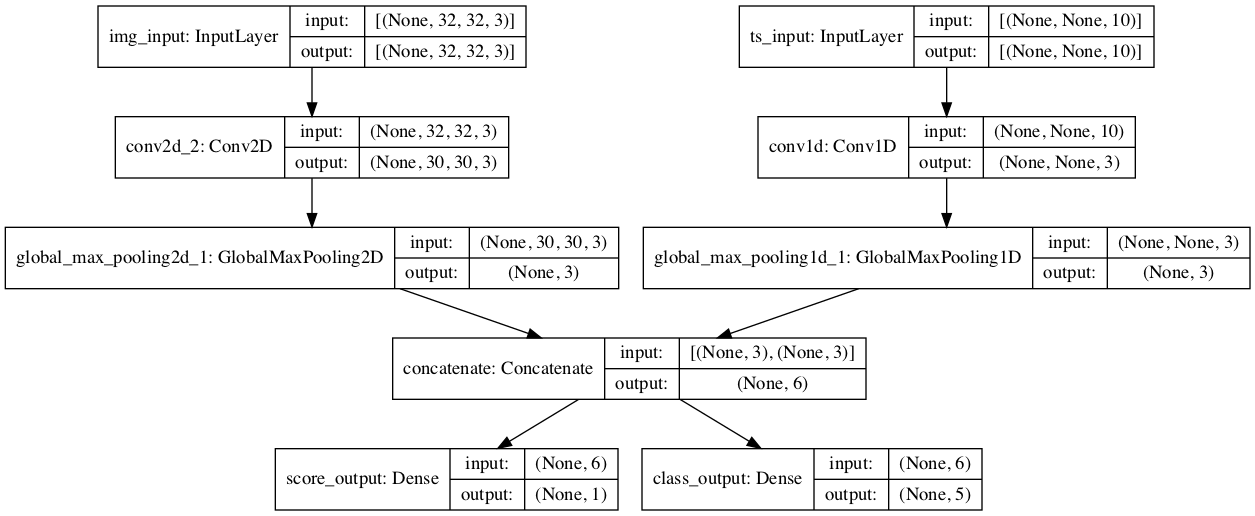

In [71]:
keras.utils.plot_model(model, show_shapes=True)

In [74]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output" : keras.losses.MeanSquaredError(), 
        "class_output" : keras.losses.CategoricalCrossentropy()
    },
    
    metrics={
        "score_output" : [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output" : [keras.metrics.CategoricalAccuracy()],
    },
    loss_weights={"score_output": 2.0, "class_output": 1.0},
)

In [75]:
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

model.fit(
    {"img_input": img_data, "ts_input": ts_data},
    {"score_output": score_targets, "class_output": class_targets},
    batch_size=32,
    epochs=1,
)

4/4 [==============================] - 1s 5ms/step - loss: 25.2296 - score_output_loss: 3.6016 - class_output_loss: 18.0264 - score_output_mean_absolute_percentage_error: 2101.9856 - score_output_mean_absolute_error: 1.8648 - class_output_categorical_accuracy: 0.2000


In [76]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"img_input": img_data, "ts_input": ts_data},
        {"score_output": score_targets, "class_output": class_targets},
    )
)

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.fit(train_dataset, epochs=1)

2/2 [==============================] - 1s 11ms/step - loss: 22.8952 - score_output_loss: 2.5058 - class_output_loss: 17.8836 - score_output_mean_absolute_percentage_error: 1600.5741 - score_output_mean_absolute_error: 1.5481 - class_output_categorical_accuracy: 0.2200


In [78]:
# callback 사용하기
model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-2,
        patience=2,
        verbose=1,
    )
    
]

model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    validation_split=0.2,
)

Epoch 1/20
625/625 [==============================] - 1s 1ms/step - loss: 0.3705 - sparse_categorical_accuracy: 0.8941 - val_loss: 0.2252 - val_sparse_categorical_accuracy: 0.9332
Epoch 2/20
625/625 [==============================] - 1s 1ms/step - loss: 0.1740 - sparse_categorical_accuracy: 0.9487 - val_loss: 0.1755 - val_sparse_categorical_accuracy: 0.9476
Epoch 3/20
625/625 [==============================] - 1s 1ms/step - loss: 0.1236 - sparse_categorical_accuracy: 0.9631 - val_loss: 0.1542 - val_sparse_categorical_accuracy: 0.9537
Epoch 4/20
625/625 [==============================] - 1s 1ms/step - loss: 0.0964 - sparse_categorical_accuracy: 0.9701 - val_loss: 0.1488 - val_sparse_categorical_accuracy: 0.9541
Epoch 5/20
625/625 [==============================] - 1s 1ms/step - loss: 0.0799 - sparse_categorical_accuracy: 0.9761 - val_loss: 0.1308 - val_sparse_categorical_accuracy: 0.9611
Epoch 6/20
625/625 [==============================] - 1s 1ms/step - loss: 0.0674 - sparse_categorica

In [79]:
# 자신만의 콜백 함수 작성

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []
        
    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))


In [80]:
# 모델 검사점 설정하기 - Modelcheckpoint

model = get_compiled_model()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="mymodel_{epoch}",
        save_best_only=True,
        monitor="val_loss",
        verbose=1,
    )
]

model.fit(
    x_train, y_train, epochs=2, batch_size=64, callbacks=callbacks, validation_split=0.2
)

Epoch 1/2
625/625 [==============================] - 1s 2ms/step - loss: 0.3632 - sparse_categorical_accuracy: 0.8974 - val_loss: 0.2371 - val_sparse_categorical_accuracy: 0.9308

Epoch 00001: val_loss improved from inf to 0.23712, saving model to mymodel_1
INFO:tensorflow:Assets written to: mymodel_1/assets
Epoch 2/2
625/625 [==============================] - 1s 1ms/step - loss: 0.1733 - sparse_categorical_accuracy: 0.9480 - val_loss: 0.1988 - val_sparse_categorical_accuracy: 0.9381

Epoch 00002: val_loss improved from 0.23712 to 0.19881, saving model to mymodel_2
INFO:tensorflow:Assets written to: mymodel_2/assets


In [92]:
import os

checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
def make_or_restore_model():
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    print(checkpoints)
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()

model = make_or_restore_model()
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + "/ckpt-loss={loss:.2f}", save_freq=100
    ), keras.callbacks.TensorBoard(
    log_dir="./tensorboard_log",
    histogram_freq=0,
    embeddings_freq=0,
    update_freq="epoch",
)
]
model.fit(x_train, y_train, epochs=1, callbacks=callbacks)

['./ckpt/ckpt-loss=0.30', './ckpt/ckpt-loss=0.37', './ckpt/ckpt-loss=0.08', './ckpt/ckpt-loss=0.39', './ckpt/ckpt-loss=0.09', './ckpt/ckpt-loss=0.31', './ckpt/ckpt-loss=0.14', './ckpt/ckpt-loss=0.46', './ckpt/ckpt-loss=0.41', './ckpt/ckpt-loss=0.15', './ckpt/ckpt-loss=0.94', './ckpt/ckpt-loss=0.34', './ckpt/ckpt-loss=0.33', './ckpt/ckpt-loss=0.50', './ckpt/ckpt-loss=0.68', './ckpt/ckpt-loss=0.57', './ckpt/ckpt-loss=0.32', './ckpt/ckpt-loss=0.35', './ckpt/ckpt-loss=0.10', './ckpt/ckpt-loss=0.43', './ckpt/ckpt-loss=0.11', './ckpt/ckpt-loss=0.16']
Restoring from ./ckpt/ckpt-loss=0.09
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0771 - sparse_categorical_accuracy: 0.9776


In [89]:
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

In [90]:
# tensorboard 콜백 사용하기

keras.callbacks.TensorBoard(
    log_dir="./tensorboard_log",
    histogram_freq=0,
    embeddings_freq=0,
    update_freq="epoch",
)

ValueError: Unrecognized arguments in `TensorBoard` Callback: {'embeddigs_freq'}